<a href="https://colab.research.google.com/github/Snrbsk/btk-manisa-yapayZeka/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0206 - val_loss: 0.0614
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0090 - val_loss: 0.0408
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0092 - val_loss: 0.0369
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0102 - val_loss: 0.0371
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0092 - val_loss: 0.0346
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0065 - val_loss: 0.0283
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0246
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0099 - val_loss: 0.0248
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0447
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0152
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - val_loss: 0.0114
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms

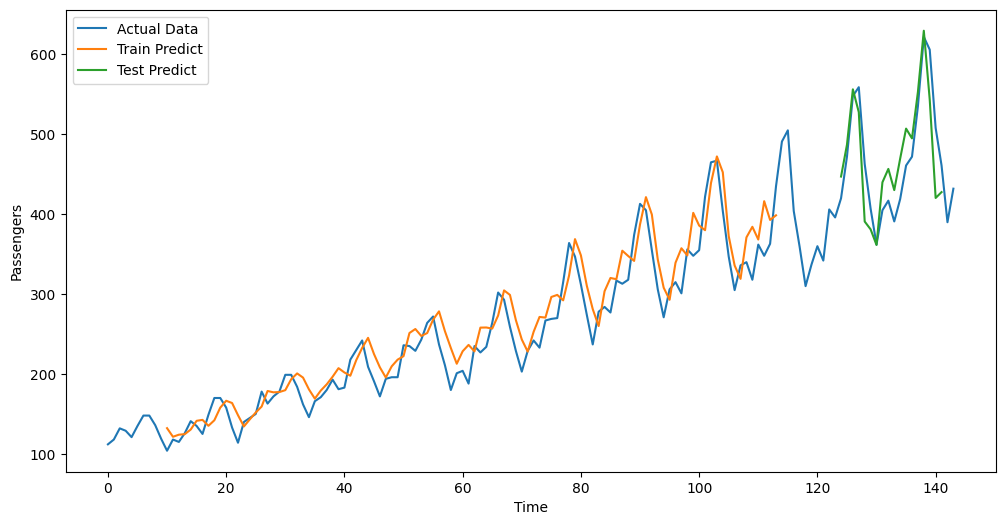

Train MAE: 23.31
Test MAE: 34.57
Train MSE: 788.61
Test MSE: 1589.08
Train RMSE: 28.08
Test RMSE: 39.86


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pickle

# Veriyi yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, usecols=[1])
data = data.values.astype('float32')

# Veriyi 0 ile 1 arasında ölçekleyelim
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma (80% eğitim, 20% test)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# LSTM modeli için veri şekillendirme
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Veriyi LSTM girişine uygun hale getirme
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTM modeli oluşturma
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test))

# Tahminler
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Tahminleri ölçeklendirmeyi geri alma
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Gerçek değerleri ölçeklendirmeyi geri alma
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Eğitim ve test verisi için tahminleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Data')
plt.plot(range(time_step, len(train_predict) + time_step), train_predict, label='Train Predict')
plt.plot(range(len(train_predict) + (time_step * 2), len(train_predict) + (time_step * 2) + len(test_predict)), test_predict, label='Test Predict')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Modeli kaydetme
model.save('air_passenger_lstm_model.h5')

from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE, MSE ve RMSE hesaplama
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')




In [ ]:
print(data)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]
